In [7]:
#Counteor for the number of errors in the grid
import os
from os.path import join
path = os.getcwd()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pydoc import ispath
import pandas as pd
import h5py
import numpy as np

parent = os.path.abspath("..")
DBS = join(parent,"results","databases")

# Change this accordingly
RESULTS_DIR = "C:\\Repos\\31_days"
RESULTS_DB_DIR = join(RESULTS_DIR, "databases")
GRID_SNAPS_DIR = join(RESULTS_DIR, "grid_snapshots")
RESULTS_POSTPROC_DIR = join(RESULTS_DIR, "postprocessed")
scenarios = ["EV", "EV_PV", "EV_PV_STO", "GRID_OBSV"]


In [58]:

counter = {}
counter_total = {}
min_v_dict={}
no_cars_list=[]
for scenario in scenarios:
    counter[scenario]=[]
    counter_total[scenario]={}
    issues_list_by_car = []
    min_v_list = []

    for n_cars in range(49,500):
    # search if folder exists
        DB_NAME = join(RESULTS_DB_DIR,f"RESULTS_{scenario}_{n_cars}.hdf5")
        if os.path.isfile(DB_NAME):
            if scenario =="EV":
                no_cars_list.append(n_cars)
            data = h5py.File(DB_NAME, "r")
    
            series = {}

            # Which datarows do I want
            series["bus"] = [b for b in data["Series"].keys() if "bus" in b.lower()]
            if scenario == "GRID_OBSV":
                series["bus"] = [b for b in data["Series"].keys() if "gridnode" in b.lower()]
            results = {}
            params = {}
            output_list=[]
            column_names = series["bus"]
            par = "vm_pu"
            for column in column_names:
                output = data["Series"][column][par]
                output = np.array(output)
                output_list.append(output)
                results[column.split("-")[-1]] = np.array(output)

            df = pd.DataFrame(results)

            #count how many values outside of the boundaries I have...
            min_v = 1
            violations= 0
            for col in df.columns:
                for x in df[col]:
                    if x<0.95:
                        violations+=1
                    if x<min_v:
                        min_v = x
            min_v_list.append(min_v)



            list_issues = []
            list_issues_serious = []
            for idx in df.index:
                issue = 0 
                voltages = [df.at[idx,c] for c in df.columns]
                if min(voltages)<0.95:
                    issue=1
                list_issues.append(issue)
                
                serious_issue= 0
                if min(voltages)<0.90:
                    serious_issue=1
                list_issues_serious.append(serious_issue)


            issues_statistic=[]
            issues_count =[]
            # there are 96 values per day
            # a maximum of 96*7/20
            max_allowed = int(round(96*7/20))
            for i, issue in enumerate(list_issues):
                problem = 0

                if i<=96*7:
                    sublist = list_issues[0:i+1]
                else:
                    sublist = list_issues[i+1-96*7:i+1]
                    assert(len(sublist)==96*7)
                week_issues = sublist.count(1)
                issues_count.append(week_issues)
                if week_issues >=max_allowed:
                    problem = 1
                
                if list_issues_serious[i]==1:
                    problem = 1


                issues_statistic.append(problem)
            issues_statistic_count=issues_statistic.count(1)
            issues_list_by_car.append(issues_statistic_count)
            counter_total[scenario][n_cars]=issues_count




    counter[scenario]=issues_list_by_car
    min_v_dict[scenario] = min_v_list
counter["n_cars"] = no_cars_list
min_v_dict["n_cars"] = no_cars_list



#counter

In [82]:
import json
with open("figs\\car_results.json", "w") as write_file:
    json.dump(counter, write_file, indent=4)

with open("figs\\car_results_totals.json", "w") as write_file:
    json.dump(counter_total, write_file, indent=4)

with open("figs\\car_results_min_v.json", "w") as write_file:
    json.dump(min_v_dict, write_file, indent=4)

In [83]:
# importing the module
import json
if not counter: 
    with open("figs\\car_results.json") as json_file:
        counter = json.load(json_file)

if not counter_total: 
    with open("figs\\car_results_totals.json") as json_file:
        counter_total = json.load(json_file)

if not min_v_dict: 
    with open("figs\\car_results_min_v.json") as json_file:
        min_v_dict = json.load(json_file)


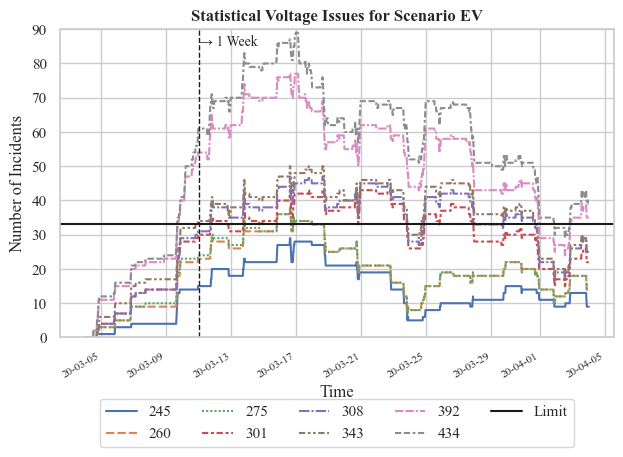

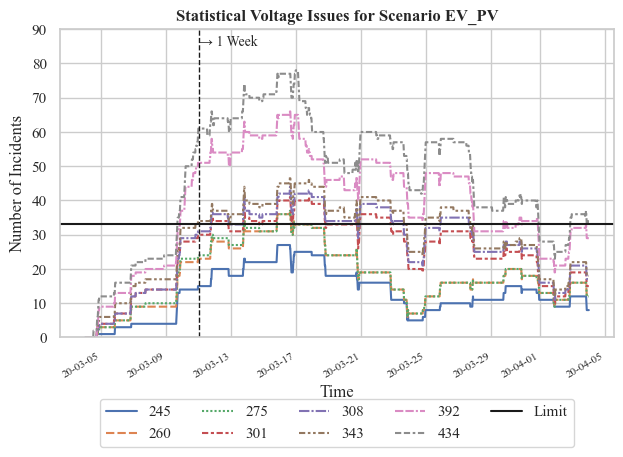

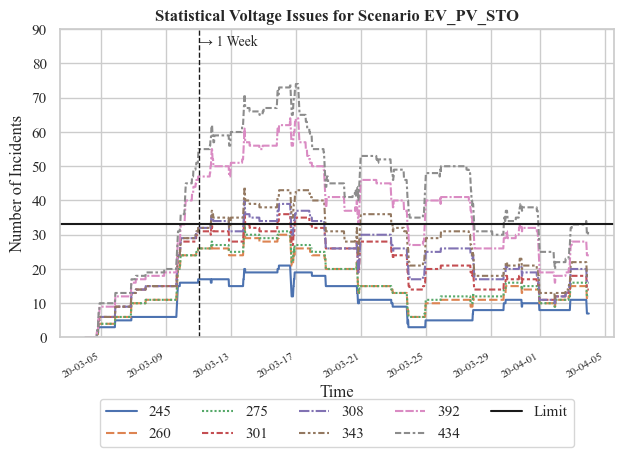

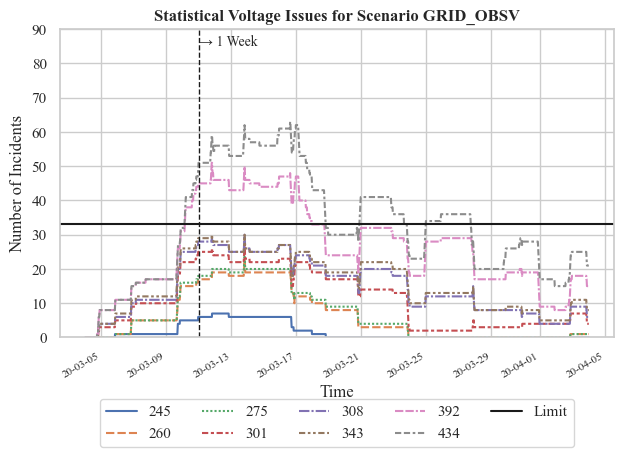

In [84]:
import warnings
warnings.filterwarnings('ignore')

for scenario in scenarios:#[0:1]: #[scenarios[0]]:
    sns.set(font = "Times New Roman", style ="whitegrid")
    data = counter_total[scenario]
    data_plot = {}
    for key in data.keys():
        if key in [245, 260, 275, 301,308,343, 392, 434]: #245, 275,294,322,343,357,371,392,413,434]:
            data_plot[key]= data[key]
    dti = pd.date_range(start="2020-03-04", periods=len(data[key]), freq="15T")
    data_plot["Time"] = dti

    df = pd.DataFrame.from_dict(data_plot)
    df.set_index("Time", inplace=True)
    sns.set(font = "Times New Roman", style ="whitegrid")
    #from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange

    fig,ax = plt.subplots()
    graph = sns.lineplot(data=df,ax=ax)
    graph.axhline(33, label = "Limit",color='k',linewidth=1.5)
    graph.axvline(data_plot["Time"][96*7],color='k', ls='--',linewidth=1)
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of Incidents")
    ax.set_title(f"Statistical Voltage Issues for Scenario {scenario}",fontweight="bold")
    ax.set_ylim(bottom=0, top=90)
    #x_dates = dti.strftime('%y-%m-%d %H:%M').sort_values().unique()

    #ax.set_xticklabels(labels=x_dates, rotation=45, ha='right', fontsize= 8)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.38),
            ncol=5)
    ax.annotate("→ 1 Week", xy=(data_plot["Time"][96*7], 85), size=10)

    #ax.fmt_xdata = DateFormatter('%yy-% m-% d ')
    plt.xticks(fontsize=8)#, rotation=90)
    import matplotlib.dates as mdates
    myFmt = mdates.DateFormatter('%y-%m-%d')# %H:%M')
    ax.xaxis.set_major_formatter(myFmt)
    fig.autofmt_xdate()

    plt.tight_layout()
    fig.savefig(f"figs\\timeseries_voltage_issues_{scenario}.png")


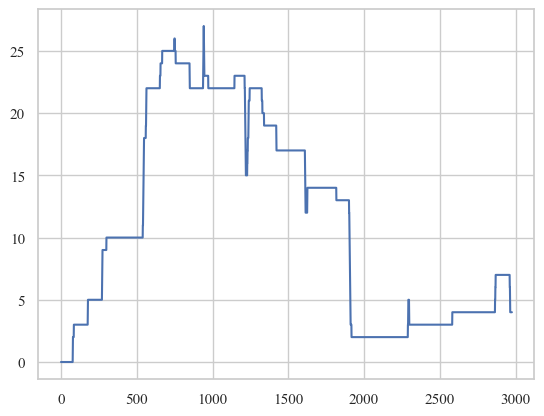

In [85]:
data = counter_total["GRID_OBSV"]
plt.plot(data[301])

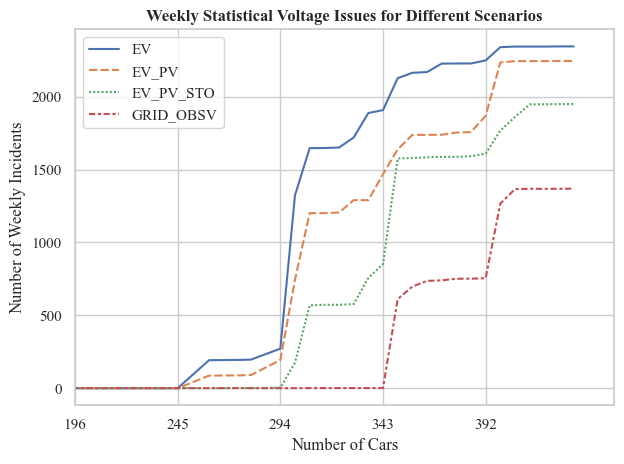

In [86]:
sns.set(font = "Times New Roman", style ="whitegrid")

counter_df = pd.DataFrame.from_dict(counter)
counter_df.set_index("n_cars", inplace=True)
#counter_df=counter_df.replace(0,np.nan)
fig,ax = plt.subplots()
graph = sns.lineplot(data=counter_df,ax=ax)
ax.set_xlabel("Number of Cars")
ax.set_ylabel("Number of Weekly Incidents")
ax.set_title("Weekly Statistical Voltage Issues for Different Scenarios",fontweight="bold")
graph.set_xticks([49*x for x in range(1,9)])
ax.set_xlim(196,)

plt.tight_layout()
fig.savefig("figs\\weekly_voltage_issues_line.png")


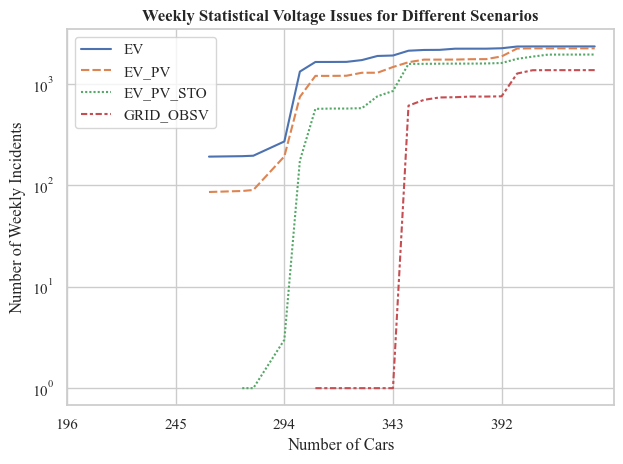

In [87]:
sns.set(font = "Times New Roman", style ="whitegrid")

counter_df_2 = pd.DataFrame.from_dict(counter)
counter_df_2.set_index("n_cars", inplace=True)
counter_df_2=counter_df_2.replace(0,np.nan)
fig,ax = plt.subplots()
graph = sns.lineplot(data=counter_df_2,ax=ax)
ax.set_xlabel("Number of Cars")
ax.set_ylabel("Number of Weekly Incidents")
ax.set_title("Weekly Statistical Voltage Issues for Different Scenarios",fontweight="bold")
graph.set_xticks([49*x for x in range(1,9)])
ax.set_yscale("log")
ax.set_xlim(196,)
plt.tight_layout()
fig.savefig("figs\\weekly_voltage_issues_line_log.png")


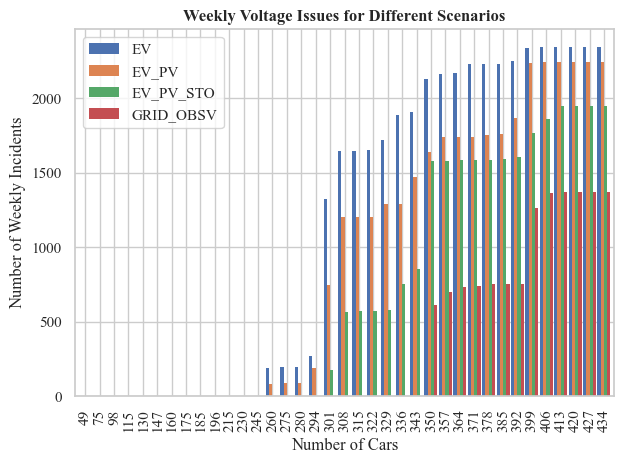

In [88]:
fig,ax = plt.subplots()
counter_df.plot.bar(ax=ax,linewidth=0, width = 0.9)
sns.set(font = "Times New Roman", style ="whitegrid")

ax.set_xlabel("Number of Cars")
ax.set_ylabel("Number of Weekly Incidents")
ax.set_title("Weekly Voltage Issues for Different Scenarios",fontweight="bold")

plt.tight_layout()
fig.savefig("figs\\weeky_voltage_issues_bar.png")

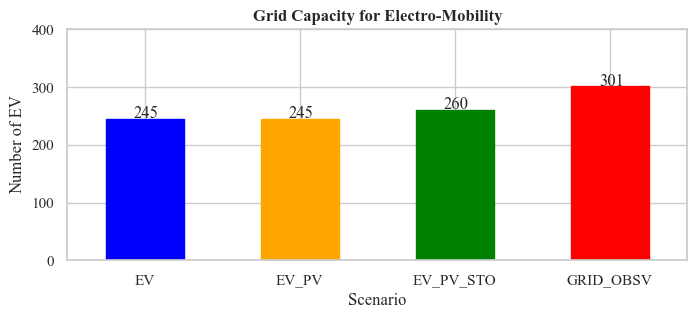

In [89]:
# Look for the limit
limits = {}
limits["Scenario"]=[]
limits["Limit"]=[]
for scenario in scenarios:
    previous_idx = None
    for idx in counter_df.index:
        if counter_df.loc[idx,scenario] == 0:
            limit = idx
    limits["Scenario"].append(scenario)
    limits["Limit"].append(limit)

with open("figs\\limits_results.json", "w") as write_file:
    json.dump(limits, write_file, indent=4)



df_limits = pd.DataFrame.from_dict(limits)
df_limits.set_index("Scenario", inplace=True)
fig,ax = plt.subplots(figsize=(8,3))

df_limits.plot.bar(ax=ax, legend = None)
colors = ["blue",  "orange", "green","red",]
i = 0
for p in ax.patches:
    p.set_color(colors[i])
    ax.annotate(str(p.get_height()), (p.get_x()+0.18 , p.get_height() * 1.005))
    i+=1
ax.set_xlabel("Scenario")
ax.set_ylabel("Number of EV")
ax.set_ylim((0,400))
ax.set_title("Grid Capacity for Electro-Mobility",fontweight="bold")
plt.xticks(rotation=0)
fig.savefig("figs\\bar_limits_v1.png")



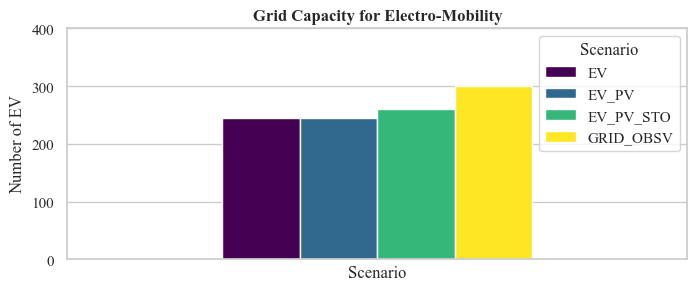

In [90]:
df_limits_t= df_limits.transpose()
fig,ax = plt.subplots(figsize=(8,3))

df_limits_t.plot.bar(ax=ax, colormap = "viridis")
plt.xticks(rotation=0)
ax.set_xlabel("Scenario")
ax.set_ylabel("Number of EV")
ax.set_ylim((0,400))

ax.set_title("Grid Capacity for Electro-Mobility",fontweight="bold")
plt.xticks([])

fig.savefig("figs\\bar_limits_v2.png")

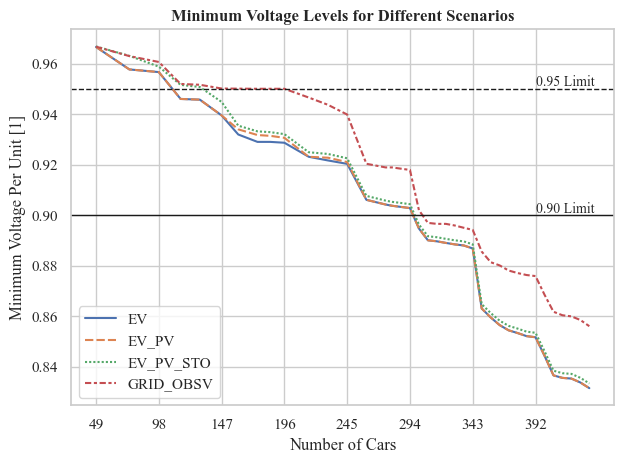

In [91]:
min_v_df = pd.DataFrame.from_dict(min_v_dict)
min_v_df.set_index("n_cars", inplace=True)

fig,ax = plt.subplots()
graph=sns.lineplot(data=min_v_df,ax=ax)
ax.set_xlabel("Number of Cars")
ax.set_ylabel("Minimum Voltage Per Unit [1]")
ax.set_title("Minimum Voltage Levels for Different Scenarios",fontweight="bold")
graph.set_xticks([49*x for x in range(1,9)])

graph.axhline(0.95, label = "0.95 Limit",color='k',ls='--',linewidth=1)
graph.axhline(0.90, label = "0.90 Limit",color='k',linewidth=1)
ax.annotate("0.95 Limit", xy=(392, 0.951), size=10)
ax.annotate("0.90 Limit", xy=(392, 0.901), size=10)
plt.tight_layout()
fig.savefig("figs\\min_voltage.png")